# Creation of Matched Datasets - 14 March 2022 Case

In order to evaluate the SAIL field campaign snowfall retrievals, a dataset containing the radar column above each of our sites of interest, matched with in-situ ground observations is desired. 

## Current List of Supported In-Situ Ground Observations
- Pluvio Weighing Bucket Precipitation Gauge [WBPLUVIO2] (DOI: 10.5439/1338194)
- Surface Meteorological Instrumentation [MET] (DOI: 10.5439/1786358)

## Planned In-Situ Ground Observations (More Suggestions Welcome!)
- Laser Disdrometer [LD] (DOI: 10.5439/1779709)
- Balloon-borne sounding system [SONDEWNPN] (DOI: 10.5439/1595321)
- Radar Wind Profiler [RWP] 

## Imports

In [69]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
from matplotlib.dates import DateFormatter
from matplotlib import colors
import pandas as pd

## Define Functions 

In [2]:
def subset_points(file, lats, lons, sites):
    """Subset a radar file for a set of latitudes and longitudes"""
    
    # Read in the file
    radar = pyart.io.read(file)
    
    column_list = []
    for lat, lon in zip(lats, lons):
        # Make sure we are interpolating from the radar's location above sea level
        # NOTE: interpolating throughout Troposphere to match sonde to in the future
        da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(radar.altitude['data'][0], 10100, 100))
        # Add the latitude and longitude of the extracted column
        da["latitude"], da["longitude"] = lat, lon
        # Time is based off the start of the radar volume
        dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
        da["time"] = [dt]
        column_list.append(da)
    # Concatenate the extracted radar columns for this scan across all sites    
    ds = xr.concat(column_list, dim='site')
    ds["site"] = sites
    # Add attributes for Time, Latitude, Longitude, and Sites
    ds.time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
                                    + " of each Individual Radar Volume Scan before"
                                    + " Concatenation"),
                         units='seconds',
                         description=('Time in Seconds that Cooresponds to the Minimum'
                                      + ' Height Gate'))
    ds.site.attrs.update(long_name="SAIL/SPLASH In-Situ Ground Observation Site Identifers")
    ds.latitude.attrs.update(long_name='Latitude of SAIL Ground Observation Site',
                             units='Degrees North')
    ds.longitude.attrs.update(long_name='Longitude of SAIL Ground Observation Site',
                             units='Degrees East')
    return ds

In [3]:
def match_datasets(column, ground, site, DataSet=False):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations
    
    Parameters
    ----------
    column : Xarray DataSet
             Xarray DataSet containing the extracted radar column above multiple locations.
             Dimensions should include Time, Height, Site
             
    ground : str 
             String containing the path of the ground instrumentation file that is desired
             to be included within the extracted radar column dataset
             
    site : str
           Location of the ground instrument. Should be included within the filename. 
             
    Returns
    -------
    ds : Xarray DataSet
         Xarray Dataset containing the time-synced in-situ ground observations with
         the inputed radar column 
    """
    # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file
        grd_ds = xr.open_dataset(ground)

    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    matched = grd_ds.resample(time='5Min', closed='right').sum(keep_attrs=True).interp(time=column.time, method='linear') 
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(site=site))
    matched = matched.expand_dims('site')
    
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(platform_id=matched.platform_id)
        matched[var].attrs.update(data_level=matched.data_level)
        matched[var].attrs.update(location_description=matched.location_description)
        matched[var].attrs.update(datastream=matched.datastream)
        matched[var].attrs.update(doi=matched.doi)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
    
    # Tranpose the xarray DataSet to match the order of dimensions across all variables
    ##column = column.transpose("time", "height", "site")
    
    return column 

## Define the Location of the SAIL Sites. 

In [4]:
# Define the splash locations [lon,lat]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
roaring_judy = [-106.8530215, 38.7170576]
M1 = [-106.987, 38.9565]

sites = ["M1", "kettle_ponds", "brush_creek", "avery_point", "pumphouse_site", "roaring_judy"]

# Zip these together!
lons, lats = list(zip(M1,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      roaring_judy))

## List the Available CSU X-Band Corrected Precipitation Radar Moments in Antenna Coordinates Version 2 (CMAC2.0) Files

#### In contrast to the Merged CSU X-Band files previously used, the CSU X-Band CMAC2.0 files have been corrected for beam blockage and clutter, as well as, undergone additional processing. 

#### Z-S Relationships previously explored are applied during the CMAC2.0 processing of the CSU X-Band data. Therefore, all we need to do now is extract the radar columns and combine with ground instruments. 

In [5]:
#file_list = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/gucxprecipradarcmacM1.c1/ppi/202203/gucxprecipradarcmacM1.c1.20220314*"))
file_list = sorted(glob.glob("/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314*"))
file_list[:10]

['/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-000239.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-001319.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-003439.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-004519.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-005039.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-011159.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-013839.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-015439.nc',
 '/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-021039.nc',
 

In [6]:
%%time
ds_list = []
for file in file_list[:]:
    print(file)
    ds_list.append(subset_points(file, lats, lons, sites))

/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-000239.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-001319.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-003439.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-004519.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-005039.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-011159.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-013839.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-015439.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-021039.nc
/Users/celsloaner/ARM/Observations/CS

/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-164524.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-165044.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-170124.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-171204.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-172244.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-173324.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-173844.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-174924.nc
/Users/celsloaner/ARM/Observations/CSU-XPrecip/SAIL/2022/cmac2/gucxprecipradarcmacM1.c1.20220314-175445.nc
/Users/celsloaner/ARM/Observations/CS

## Combine all Extracted Radar Columns to Form Daily Timeseries

In [7]:
ds = xr.concat(ds_list, dim='time')

In [8]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 70, site: 6, time: 118)
Coordinates:
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
  * site                                      (site) <U14 'M1' ... 'roaring_j...
Data variables: (12/35)
    DBZ                                       (time, site, height) float64 na...
    VEL                                       (time, site, height) float64 na...
    WIDTH                                     (time, site, height) float64 na...
    ZDR                                       (time, site, height) float64 na...
    PHIDP                                     (time, site, height) float64 na...
    RHOHV                                     (time, site, height) float64 na...
    ...                                        ...
    snow_rate_ws88diw                         (time, site, height) float64 na...
    snow_rate_m2009_1                         (time, site, height) float64 na...
    snow_rate_m2009_2                         (time, site, height) float64 na...
    base_time                                 (time, site) datetime64[ns] 197...
    latitude                                  (time, site) float64 38.96 ... ...
    longitude                                 (time, site) float64 -107.0 ......
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

## 1) Add in the Pluvio Weighing Bucket Data

In [9]:
# Define the file path
npluvio = "/Users/celsloaner/ARM/Observations/WPLUVIO2/gucwbpluvio2M1.a1.20220314.000000.nc"
# Define the site location based on the filename
pluv_site = npluvio.split('gucwbpluvio2')[-1].split('.')[0]

In [10]:
ds = match_datasets(ds, npluvio, pluv_site)

/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfradial1' loading failed:
The 'geopandas' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfradial2' loading failed:
The 'geopandas' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'furuno' loading failed:
The 'geopandas' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'gamic' loa

In [11]:
ds = ds.transpose("time", "height", "site")

In [12]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 70, site: 6, time: 118)
Coordinates:
  * site                                      (site) <U14 'M1' ... 'roaring_j...
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
Data variables: (12/53)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    maintenance_flag                          (time, site) float64 0.0 ... nan
    reset_flag                                (time, site) float64 0.0 ... nan
    volt_min                                  (time, site) float64 60.7 ... nan
    ptemp                                     (time, site) float64 34.72 ... nan
    intensity_rtnrt                           (time, site) float64 0.0 ... nan
    alt                                       (time, site) float64 2.886e+03 ...
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

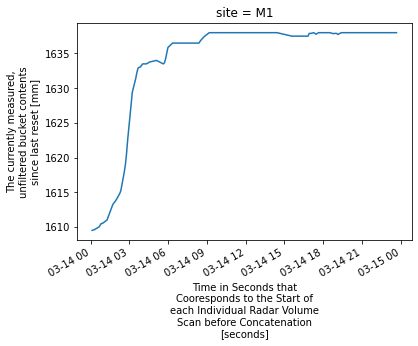

In [13]:
ds.sel(site='M1').bucket_rt.plot(x='time')

## 2) Add the Surface Meteorological Station (MET) to the Matched Dataset

In [14]:
# Define the file path
nmet = "/Users/celsloaner/ARM/inProgress/gucmetM1.b1.20220314.000000.cdf"
# Define the site location based on the filename
met_site = nmet.split('gucmet')[-1].split('.')[0]

In [15]:
ds = match_datasets(ds, nmet, met_site)

In [16]:
#ds = ds.transpose("time", "height", "site")

In [17]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 70, site: 6, time: 118)
Coordinates:
  * site                                      (site) <U14 'M1' ... 'roaring_j...
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
Data variables: (12/98)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    tbrg_precip_total_corr                    (site, time) float64 0.0 ... nan
    qc_tbrg_precip_total_corr                 (site, time) float64 0.0 ... nan
    logger_volt                               (site, time) float64 58.46 ... nan
    qc_logger_volt                            (site, time) float64 0.0 ... nan
    logger_temp                               (site, time) float64 51.3 ... nan
    qc_logger_temp                            (site, time) float64 0.0 ... nan
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

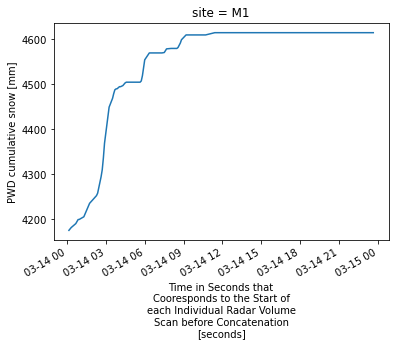

In [18]:
ds.sel(site='M1').pwd_cumul_snow.plot(x='time')

## 3) Add the Laser Disdrometer to the Matched Dataset  - M1 Sites

In [19]:
# Define the file path
nld = "/Users/celsloaner/ARM/inProgress/gucldM1.b1.20220314.000000.cdf"
# Define the site location based on the filename
ld_site = nld.split('gucld')[-1].split('.')[0]

In [20]:
ds = match_datasets(ds, nld, ld_site)

In [21]:
# Note: Dropping altitude variable of LD, in order to include Sonde Altitude in next section
ds = ds.drop_vars('alt')

In [22]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 70, particle_size: 32, raw_fall_velocity: 32, site: 6, time: 118)
Coordinates:
  * site                                      (site) <U14 'M1' ... 'roaring_j...
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
  * particle_size                             (particle_size) float32 0.062 ....
  * raw_fall_velocity                         (raw_fall_velocity) float32 0.0...
Data variables: (12/134)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    moment1                                   (site, time) float64 341.9 ... nan
    moment2                                   (site, time) float64 347.9 ... nan
    moment3                                   (site, time) float64 596.5 ... nan
    moment4                                   (site, time) float64 1.904e+03 ...
    moment5                                   (site, time) float64 9.381e+03 ...
    moment6                                   (site, time) float64 5.713e+04 ...
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

## 4) Add Second Laser Disdrometer - S2 Site

In [23]:
# Define the file path
ld_2 = "/Users/celsloaner/ARM/inProgress/gucldS2.b1.20220314.000000.cdf"
# Define the site location based on the filename
ld2_site = ld_2.split('gucld')[-1].split('.')[0]
print(ld2_site)

S2


In [24]:
ds = match_datasets(ds, ld_2, ld2_site)

In [25]:
# Note: Dropping altitude variable of LD, in order to include Sonde Altitude in next section
ds = ds.drop_vars('alt')

In [26]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 70, particle_size: 32, raw_fall_velocity: 32, site: 7, time: 118)
Coordinates:
  * site                                      (site) <U14 'M1' ... 'roaring_j...
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
  * particle_size                             (particle_size) float32 0.062 ....
  * raw_fall_velocity                         (raw_fall_velocity) float32 0.0...
Data variables: (12/134)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    moment1                                   (site, time) float64 341.9 ... nan
    moment2                                   (site, time) float64 347.9 ... nan
    moment3                                   (site, time) float64 596.5 ... nan
    moment4                                   (site, time) float64 1.904e+03 ...
    moment5                                   (site, time) float64 9.381e+03 ...
    moment6                                   (site, time) float64 5.713e+04 ...
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

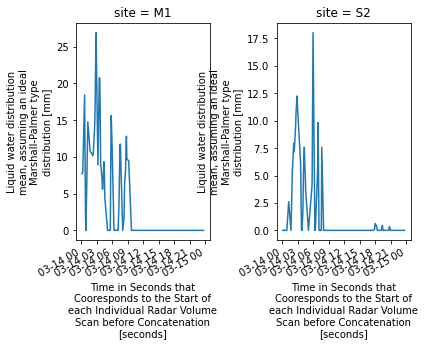

In [27]:
fig, axarr = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5, hspace=1.2)

ds.liquid_water_distribution_mean.sel(site='M1').sel(time=slice("2022-03-14",
                                                                "2022-03-15")).plot(ax=axarr[0])
ds.liquid_water_distribution_mean.sel(site='S2').sel(time=slice("2022-03-14",
                                                                "2022-03-15")).plot(ax=axarr[1])

## 5) Add the Radiosonde Data

### Note: There could be multiple launches per day and not all are successful. 

In [28]:
# Search for all sonde files
nsonde = sorted(glob.glob("/Users/celsloaner/ARM/inProgress/gucsondewnpnM1*"))
sonde_list = []
# Open each individual Sonde File and Merge together
for nfile in nsonde:
    sonde = xr.open_dataset(nfile)
    # Check to make sure launch was successful (e.g. time > 1 obs)
    if sonde.time.shape[0] > 1:
        print('successful flight', nfile)
        sonde_list.append(sonde)
# Concatenate together the sonde xarray DataSets
ds_sonde = xr.concat(sonde_list, dim='time')
# Define the site location based on the filename
sonde_site = nsonde[0].split('gucsondewnpn')[-1].split('.')[0]

successful flight /Users/celsloaner/ARM/inProgress/gucsondewnpnM1.b1.20220314.233000.cdf


In [29]:
sonde_site

'M1'

In [30]:
ds_sonde

<xarray.Dataset>
Dimensions:      (time: 5699)
Coordinates:
  * time         (time) datetime64[ns] 2022-03-14T23:30:00 ... 2022-03-15T01:...
Data variables: (12/24)
    base_time    (time) datetime64[ns] 2022-03-14 2022-03-14 ... 2022-03-14
    time_offset  (time) datetime64[ns] 2022-03-14T23:30:00 ... 2022-03-15T01:...
    pres         (time) float32 721.1 720.6 720.1 719.7 ... 13.77 13.76 13.75
    qc_pres      (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    tdry         (time) float32 -1.5 -1.28 -1.3 -1.18 ... -53.11 -53.14 -53.14
    qc_tdry      (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ...           ...
    wstat        (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    asc          (time) float32 0.0 2.6 5.6 5.1 5.8 6.3 ... 5.0 5.4 5.5 5.0 4.1
    qc_asc       (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    lat          (time) float32 38.96 38.96 38.96 38.96 ... 38.36 38.36 38.36
    lon          (time) float32 -107.0 -107.0 -107.0 ... -106.6 -106.6 -106.6
    alt          (time) float32 2.898e+03 2.904e+03 ... 2.879e+04 2.88e+04
Attributes: (12/32)
    command_line:               sonde_ingest -s guc -f M1
    Conventions:                ARM-1.2
    process_version:            ingest-sonde-10.14-1.el7
    dod_version:                sondewnpn-b1-2.3
    input_source:               /data/collection/guc/gucsondeM1.00/good.2022M...
    site_id:                    guc
    ...                         ...
    latitude_calculation:       lat[k-1]+((v_wind[k]-v_wind[k-1])/2)*delta_ti...
    longitude_calculation:      lon[k-1]+((u_wind[k]-u_wind[k-1])/2)*delta_ti...
    sonde_pc_software_version:  2.17
    sounding_number:            ///
    doi:                        10.5439/1595321
    history:                    created by user dsmgr on machine procnode2 at...

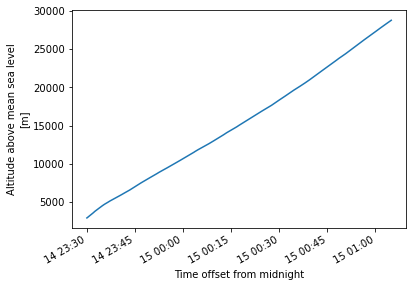

In [31]:
ds_sonde.alt.plot()

In [32]:
ds = match_datasets(ds, ds_sonde, sonde_site, DataSet=True)

In [33]:
ds

<xarray.Dataset>
Dimensions:                                   (height: 70, particle_size: 32, raw_fall_velocity: 32, site: 7, time: 118)
Coordinates:
  * site                                      (site) <U14 'M1' ... 'roaring_j...
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
  * particle_size                             (particle_size) float32 0.062 ....
  * raw_fall_velocity                         (raw_fall_velocity) float32 0.0...
Data variables: (12/154)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    v_wind                                    (site, time) float64 nan ... nan
    qc_v_wind                                 (site, time) float64 nan ... nan
    wstat                                     (site, time) float64 nan ... nan
    asc                                       (site, time) float64 nan ... nan
    qc_asc                                    (site, time) float64 nan ... nan
    alt                                       (site, time) float64 nan ... nan
Attributes:
    distance_from_radar:    7.491 km
    azimuth:                329.64 degrees
    latitude_of_location:   38.9565 degrees
    longitude_of_location:  -106.987 degrees

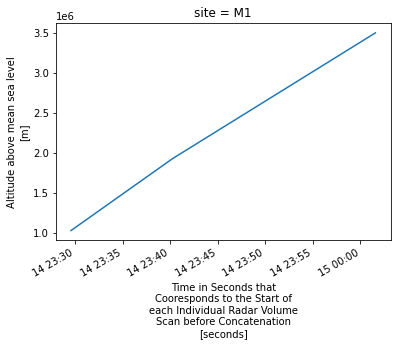

In [34]:
ds.sel(site='M1').alt.plot()

## Plot the Matched Dataset for the M1 Site

## Matched DataSet Figure - Radar, LD, Snowfall Rates, Cumulative Snowfall

In [47]:
# Define the 4 relationships within the files. 
# This meta data should be included within the CMAC files in the future
zs_relationship = {"Wolf and Snider":
                        {"A": 110,
                         "B": 2,
                         "key": "snow_rate_ws2012"},
                        "WSR 88D High Plains":
                        {"A": 130,
                         "B": 2,
                         "key": "snow_rate_ws88diw"},
                        "Matrosov et al.(2009) Braham(1990) 1":
                        {"A": 67,
                         "B": 1.28,
                         "key": "snow_rate_m2009_1"},
                         "Matrosov et al.(2009) Braham(1990) 2":
                        {"A": 114,
                         "B": 1.39,
                         "key": "snow_rate_m2009_2"}
                       }

## Re-sample the DataSet

In [80]:
ds_resampled = ds.sel(site='M1').resample(time="1T").mean().isel(height=4)

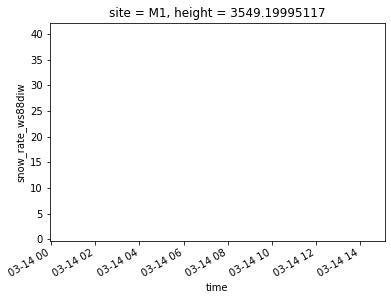

In [82]:
ds_resampled[zs_relationship["WSR 88D High Plains"]["key"]].plot()

In [ ]:
for field in zs_relationships.keys():
    #ds_resampled[field].attrs["units"] = "mm/hr"
    

In [46]:
ds.sel(site="M1")[zs_relationship["Wolf and Snider"]["key"]]

<xarray.DataArray 'snow_rate_ws2012' (time: 118, height: 70)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,  4.67203143, ...,         nan,
                nan,         nan],
       [        nan,         nan, 13.5989154 , ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    site     <U14 'M1'
  * height   (height) float64 3.149e+03 3.249e+03 ... 9.949e+03 1.005e+04
  * time     (time) datetime64[ns] 2022-03-14T00:06:47 ... 2022-03-15T00:01:36
Attributes:
    units:          mm/h
    standard_name:  snowfall_rate
    long_name:      Snowfall rate from Z using Wolf and Snider (2012)
    valid_max:      500
    valid_min:      0
    coordinates:    elevation azimuth range

In [53]:
#------------------
# Snowfall Rates
#------------------
for relationship in zs_relationship.keys():
    print(relationship)
    a_coefficient = zs_relationship[relationship]["A"]
    b_coefficient = zs_relationship[relationship]["B"]
    print(a_coefficient, b_coefficient)
    relationship_equation = f"$Z = {a_coefficient}S^{b_coefficient}$"
    print(relationship_equation)
    ds.sel(site="M1").isel(height=0)[zs_relationship[relationship]["key"]]

    #ds.isel(height=0)[relationship["key"]].plot(label=f'{relationship_name} ({relationship_equation})',
    #                                             ax=axs[3])
    #axs[3].xaxis.set_major_formatter(date_form)

Wolf and Snider
110 2
$Z = 110S^2$
WSR 88D High Plains
130 2
$Z = 130S^2$
Matrosov et al.(2009) Braham(1990) 1
67 1.28
$Z = 67S^1.28$
Matrosov et al.(2009) Braham(1990) 2
114 1.39
$Z = 114S^1.39$


'\n#-----------------\n# Snowfall Rates\n#-----------------\n\nws_equation = f"$Z = 110S^2$"\nws_label = f\'{zs_relationship["Wolf and Snider"]} ({ws_equation})\'\n# Plot the Un-Corrected Reflecitivty factor for the M1 Site. \nds.snow_rate_ws2012.sel(site=\'M1\').sel(time=slice(\'2022-03-14T00\',\n                                                  \'2022-03-14T19\')).isel(height=0).cumsum("time").plot(x=\'time\',\n                                                                                                       ax=axs[2],\n                                                                                                       label=ws_label)\n\nhp_equation = f"$Z = 130S^2$"\nhp_label = f\'{zs_relationship["WSR 88D High Plains"]} ({hp_equation})\'\n# Plot the Un-Corrected Reflecitivty factor for the M1 Site. \nds.snow_rate_ws88diw.sel(site=\'M1\').sel(time=slice(\'2022-03-14T00\',\n                                                  \'2022-03-14T19\')).isel(height=0).cumsum("time").plot(

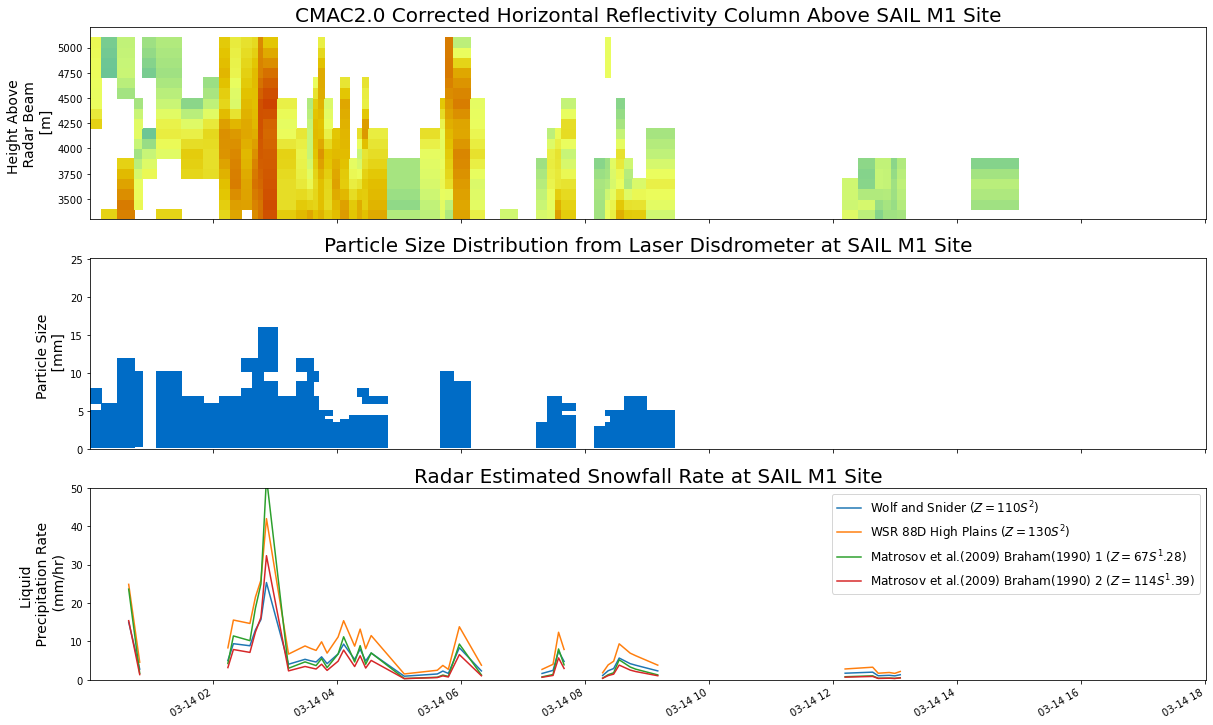

In [66]:
# Define figure and axes 
fig, axs = plt.subplots(4, 1, figsize=[20,12], sharex=True)
#plt.subplots_adjust(hspace=0.8, wspace=0.3)

#--------------
# Reflectivity
#--------------
# Plot the Corrected Reflectivity factor for the M1 site. 
# Event took place between 0Z-5Z on 14 March 2022. Slice for those times. 
ref_clabel = "Corrected \n Reflectivity \n [dBZ]"
dbz_plot = ds.corrected_reflectivity.sel(site='M1').sel(time=slice('2022-03-14T00', 
                                                                   '2022-03-14T17')).plot(x='time',
                                                                                          cmap='pyart_HomeyerRainbow',
                                                                                          vmin=-20,
                                                                                          vmax=40,
                                                                                          ax=axs[0],
                                                                                          add_colorbar=False,
                                                                                         )
# Limit the height of the beam as storm was shallow
axs[0].set_ylim([3300, 5200])
# Rename the Axes
axs[0].set_xlabel('')
axs[0].set_ylabel("Height Above \n Radar Beam \n [m]", fontsize=14)
axs[0].set_title(f"CMAC2.0 Corrected Horizontal Reflectivity Column Above SAIL M1 Site", fontsize=20)

#-------------------
# Laser Disdrometer
#-------------------
# Drop Size Distribution
norm = colors.LogNorm(vmin=ds.sel(site='M1').number_density_drops.values.min()+1,
                      vmax=ds.sel(site='M1').number_density_drops.values.max())


dsd_plot = ds.sel(site='M1').sel(time=slice("2022-03-14T00",
                                            "2022-03-14T17")).number_density_drops.plot(x="time",
                                                                                        y="particle_size",
                                                                                        norm=norm,
                                                                                        cmap="pyart_HomeyerRainbow",
                                                                                        add_colorbar=False,
                                                                                        ax=axs[1])
# Rename the labels. 
axs[1].set_ylabel('Particle Size \n [mm]', fontsize=14)
axs[1].set_xlabel("")
axs[1].set_title(f'Particle Size Distribution from Laser Disdrometer at SAIL M1 Site', fontsize=20)

#------------------
# Snowfall Rates
#------------------
for relationship in zs_relationship.keys():
    a_coefficeint = zs_relationship[relationship]["A"]
    b_coefficeint = zs_relationship[relationship]["B"]
    relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"

    ds.sel(site="M1").isel(height=3)[zs_relationship[relationship]["key"]].plot(
                                                                                label=f'{relationship} ({relationship_equation})',
                                                                                ax=axs[2])

axs[2].set_title(f"Radar Estimated Snowfall Rate at SAIL M1 Site", fontsize=20)
axs[2].legend(loc='upper right', fontsize=12)
axs[2].set_xlabel("")
axs[2].set_ylabel("Liquid \n Precipitation Rate \n (mm/hr)", fontsize=14)
axs[2].set_ylim(0, 50)

#----------------------
# Cumulative Snowfall
#----------------------
for relationship in zs_relationship_dict.keys():
    relationship_name = relationship.replace("_", " ")
    a_coefficeint = ds[relationship].A
    b_coefficeint = ds[relationship].B
    relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"

    (ds_resampled[relationship+"_accumulated"]).plot(label=f'{relationship_name} ({relationship_equation})',
                                                   ax=ax4)
    ax4.xaxis.set_major_formatter(date_form)


disdrometer_precip_accum.plot(ax=ax4,
                              label= f"Laser Disdrometer ({laser_disdrometer_ds.datastream})",
                             )

gauge_precip_accum.plot(ax=ax4,
                        label=f"Pluvio Sensor ({pluvio_ds.datastream})"
                       )

ax4.set_title(f"Cumulative Precipitation Comparison with AMF Sensors", fontsize=20)

ax4.scatter(datetime(2022, 3, 14, 13, 30),
            4.826,
            c="k",
            s=100,
            marker="x",
            label="Snowfall Observation from Gothic Weather")

#axs[2].set_xlim(time_min, time_max)
"""
#Reflectivity colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.715, 0.02, 0.165])
cbar = fig.colorbar(dbz_plot, orientation="vertical", ax=axs[0], cax=cbar_ax)
cbar.set_ticklabels(np.arange(-20, 50, 10))
cbar.set_label(label='Corrected Horizontal \n Reflectivity \n Factor ($Z_{H}$) \n (dBZ)', fontsize=16)

# Particle Size Distribution colorbar
#fig.subplots_adjust(right=0.88)
cbar_ax2 = fig.add_axes([0.9, 0.52, 0.02, 0.165])
cbar2 = fig.colorbar(dsd_plot, orientation="vertical", ax=axs[1], cax=cbar_ax2)
cbar2.set_ticklabels(cbar2.get_ticks(), size=14)
cbar2.set_label(label='Number Density \n Per Unit \n Volume \n ($m^{-3}$ $mm$)', fontsize=16)

"""

TypeError: 'module' object is not callable

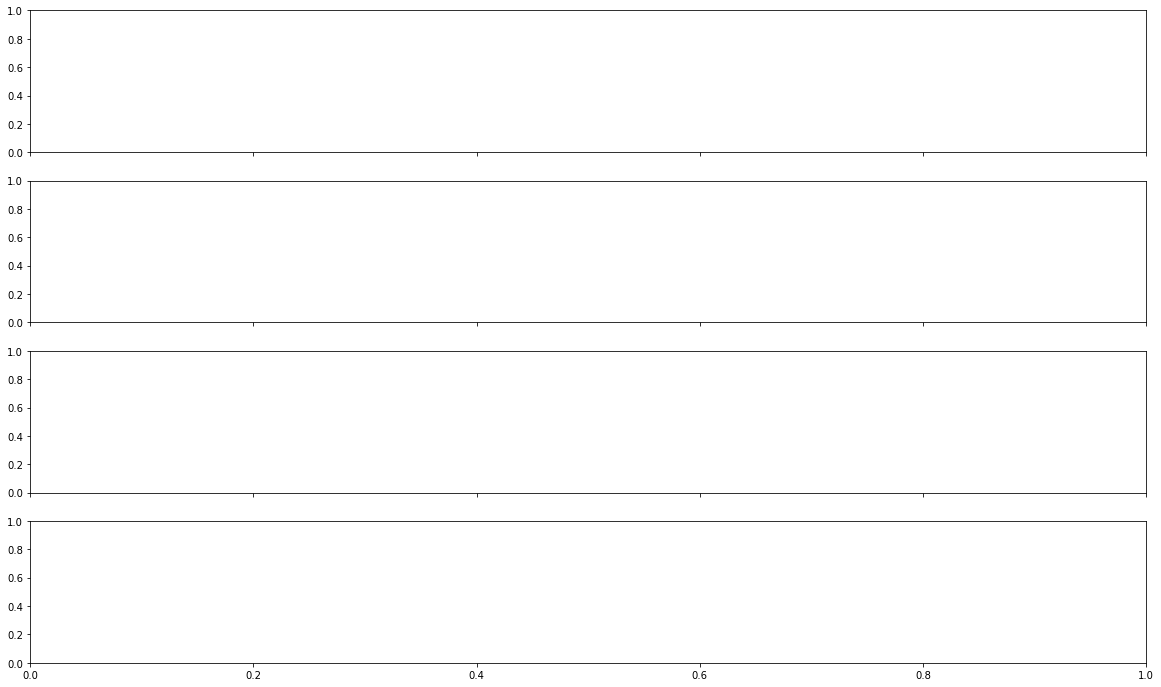

In [40]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,12))
time_min = datetime(2022, 3, 14, 0)
time_max = datetime(2022, 3, 14, 18)


date_form = DateFormatter("%H%M UTC %b %d %Y")

#------------------
# Reflectivity Plot
#------------------
dbz_plot = ds.DBZ.plot(cmap='pyart_HomeyerRainbow',
                       vmin=-20,
                       vmax=40,
                       ax=ax1,
                       add_colorbar=False,
                       figure=fig,
                       x='time')

ax1.set_ylim(0, 1800)
ax1.set_ylabel("Height Above Ground \n (m)", fontsize=14)
ax1.set_xlabel("")

ax1.set_title(f'Horizontal Reflectivity at ARM AMF Site', fontsize=20)



ax1.xaxis.set_major_formatter(date_form)
ax1.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')

ax1.legend(loc='upper right', fontsize=12)

date_form = DateFormatter("%H%M UTC %b %d %Y")
ax1.set_xlim(time_min, time_max)

# Drop Size Distribution
norm = colors.LogNorm(vmin=laser_disdrometer_ds.number_density_drops.values.min()+1,
                      vmax=laser_disdrometer_ds.number_density_drops.values.max())

dsd_plot = laser_disdrometer_ds.sel(time=slice("2022-03-14T00",
                                               "2022-03-14T17")).number_density_drops.plot(x="time",
                                                                                          y="particle_size",
                                                                                          norm=norm,
                                                                                          cmap="pyart_HomeyerRainbow",
                                                                                          add_colorbar=False,
                                                                                          ax=ax2)
ax2.set_ylim(0, 15)
ax2.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')
ax2.legend(loc='upper right', fontsize=12)
ax2.set_ylabel("Particle Size \n (mm)", fontsize=14)
ax2.set_xlabel("")
ax2.set_title(f'Particle Size Distribution from AMF Laser Disdrometer', fontsize=20)
ax2.set_xlim(time_min, time_max)

### Particle Size Distributions
site_name = ds_at_site.site.values
for relationship in zs_relationship_dict.keys():
    relationship_name = relationship.replace("_", " ")
    a_coefficeint = ds[relationship].A
    b_coefficeint = ds[relationship].B
    relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"

    ds_at_site.isel(height=0)[relationship].plot(label=f'{relationship_name} ({relationship_equation})',
                                                 ax=ax3)
    ax3.xaxis.set_major_formatter(date_form)



ax3.set_title(f"Radar Estimated Snowfall Rate at ARM AMF Site", fontsize=20)

ax3.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')

ax3.legend(loc='upper right', fontsize=12)
ax3.set_xlabel("")
ax3.set_ylabel("Liquid \n Precipitation Rate \n (mm/hr)", fontsize=14)
ax3.set_ylim(0, 30)
ax3.set_xlim(time_min, time_max)

site_name = ds_at_site.site.values
for relationship in zs_relationship_dict.keys():
    relationship_name = relationship.replace("_", " ")
    a_coefficeint = ds[relationship].A
    b_coefficeint = ds[relationship].B
    relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"

    (ds_resampled[relationship+"_accumulated"]).plot(label=f'{relationship_name} ({relationship_equation})',
                                                   ax=ax4)
    ax4.xaxis.set_major_formatter(date_form)


disdrometer_precip_accum.plot(ax=ax4,
                              label= f"Laser Disdrometer ({laser_disdrometer_ds.datastream})",
                             )

gauge_precip_accum.plot(ax=ax4,
                        label=f"Pluvio Sensor ({pluvio_ds.datastream})"
                       )

ax4.set_title(f"Cumulative Precipitation Comparison with AMF Sensors", fontsize=20)

ax4.scatter(datetime(2022, 3, 14, 13, 30),
            4.826,
            c="k",
            s=100,
            marker="x",
            label="Snowfall Observation from Gothic Weather")

ax4.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')
ax4.set_xlim(time_min, time_max)

plt.legend(loc='upper right', fontsize=8)
plt.xlabel("")
plt.ylabel("Total Precipitation \n Since 0000 UTC \n (mm)", fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=12)
plt.ylim(0, 15)

# Reflectivity colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.715, 0.02, 0.165])
cbar = fig.colorbar(dbz_plot, orientation="vertical", ax=ax1, cax=cbar_ax)
cbar.set_ticklabels(np.arange(-20, 50, 10), fontsize=14)
cbar.set_label(label='Horizontal \n Reflectivity \n Factor ($Z_{H}$) \n (dBZ)', fontsize=16)

# Particle Size Distribution colorbar
fig.subplots_adjust(right=0.88)
cbar_ax2 = fig.add_axes([0.9, 0.52, 0.02, 0.165])
cbar2 = fig.colorbar(dsd_plot, orientation="vertical", ax=ax2, cax=cbar_ax2)
cbar2.set_ticklabels(cbar2.get_ticks(), fontsize=14)
cbar2.set_label(label='Number Density \n Per Unit \n Volume \n ($m^{-3}$ $mm$)', fontsize=16)

plt.savefig("ppi_precip_estimate_pluvio.png", bbox_inches="tight", dpi=300)